# copan 重写版本

推荐：开始时候用jupyter notebook 来整理其中的变量重写比较好

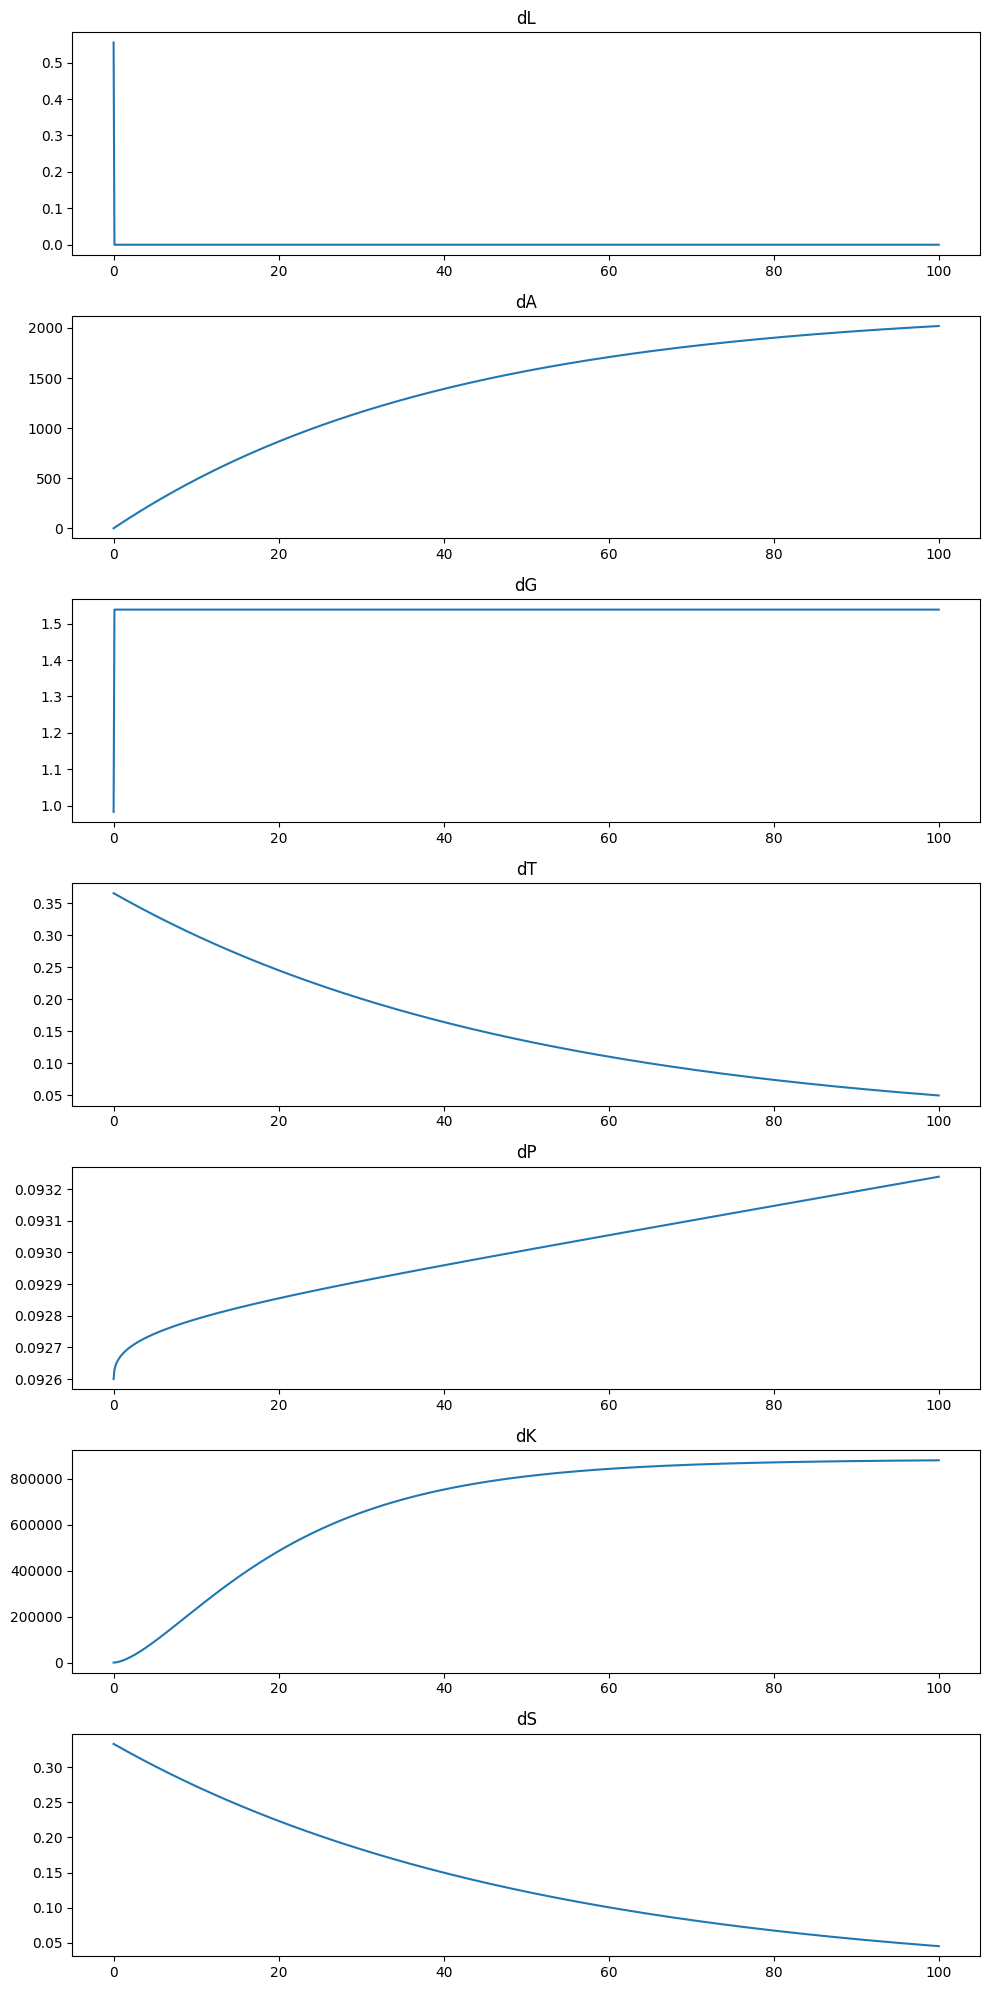

In [1]:
""""copan_exploration direct_W.ipynb
重新书写的版本内容不包含
自然保护过程，只考虑其中的参数动态

"""
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt


# def dDynVar(LAGTPKS, t):
#     L, A, G, T, P, K, S = LAGTPKS
#     U = (A / (1 + (G / sigma)**rho))
#     F = U / (1 + (S / sigma)**rho)
#     R = U - F
#     E = F / phi
#     Ldot = E - L / tau_L
#     Adot = (beta - theta * L) * A
#     Gdot = R - G / tau_G
#     Tdot = (1 - (G / sigma)**rho) * (1 - T) * F / (epsilon * tau_T)
#     Pdot = (1 - (S / sigma)**rho) * (1 - P) * F / (epsilon * tau_P)
#     Kdot = (1 - (S / sigma)**rho) * (1 - K) * F / (epsilon * tau_K)
#     Sdot = R - S / tau_S
#     return Ldot, Adot, Gdot, Tdot, Pdot, Kdot, Sdot

# L, G, P, K, S = 2480., 1125, 6e9, 6e13, 5e11

class cG_LAGTPKS_Environment():
    # 这样就是 self 的属性了
    Sigma = 1.5 * 1e8
    Cstar = 5500
    a0 = 0.03
    aT = 3.2 * 1e3
    l0 = 26.4
    lT = 1.1 * 1e6
    delta = 0.01
    m = 1.5
    g = 0.02
    p = 0.04
    Wp = 2000
    q0 = 20
    b = 5.4 * 1e-7
    yE = 147
    eB = 4 * 1e10
    eF = 4 * 1e10
    i = 0.25
    k0 = 0.1
    aY = 0.
    aB = 3e5
    aF = 5e6
    aR = 7e-18
    sS = 1. / 50.
    sR = 1.
    ren_sub = .5
    carbon_tax = .5
    i_DG = 0.1
    L0 = 0

    # 自定义的参数部分
    expP = 2. / 5
    expK = 2. / 5.

    Wl = 2000

    def __init__(self) -> None:
        # self.state = [0, 0, 0, 0, 0]
        # self.iniDynVar['L'] = 0.5
        # self.iniDynVar['A'] = 0.3
        # self.iniDynVar['G'] = 0.2
        # self.iniDynVar['T'] = 0.1
        # self.iniDynVar['P'] = 0.4
        # self.iniDynVar['K'] = 0.6
        # self.iniDynVar['S'] = 0.7

        self.state = [0, 0, 0, 0, 0, 0, 0]
        self.A_PB = 0
        self.t = 0

        # self.params={}
        # self.params['Sigma'] = self.Sigma
        # self.params['i'] = self.i
        # self.params['wL'] = self.Wp
        # self.params['yE'] = self.yE

        # self.params['eB'] = self.eB
        # self.params['eF'] = self.eF
        # self.params['aR'] = self.aR

        # self.params['g'] = self.g
        # self.params['k0'] = self.k0

        # self.params['sR'] = self.sR
        # self.params['sS'] = self.sS

        # self.params['l0'] = self.l0

    def B(self, L, P, K, G, S):
        # 完整的过程计算部分
        Xb = self.aB * L ** 2  # L
        Xf = self.aF * G ** 2
        Xr = self.aR * S ** 2
        X = Xb + Xf + Xr

        Z = P ** self.expP * K ** self.expK / X ** (4. / 5.)
        final_B = Xb * Z / self.eB

        return final_B

    def F(self, G, P, K, L, S):
        Xb = self.aB * L ** 2
        Xf = self.aF * G ** 2  # G
        Xr = self.aR * S ** 2
        X = Xb + Xf + Xr

        Z = P ** self.expP * K ** self.expK / X ** (4. / 5.)
        final_F = Xf * Z / self.eF

        return final_F

    def R(self, S, P, K, L, G):
        Xb = self.aB * L ** 2
        Xf = self.aF * G ** 2
        Xr = self.aR * S ** 2  # S
        X = Xb + Xf + Xr

        Z = P ** self.expP * K ** self.expK / X ** (4. / 5.)
        final_R = Xr * Z / self.aR

        return final_R

    def Y(self, B, F, R):
        return self.yE * (self.eB * B + self.eF * F + R)

    def W(self, Y, P, L):
        return (1. - self.i) * Y / P + self.Wl * L / self.Sigma

    # TODO 加入参数部分，仿照 ays 中操作
    def dDynVar(self, LAGTPKS, t=0):
        # 1 基本量拿取
        L, A, G, T, P, K, S = LAGTPKS


        # 2 中间量计算
        # 包含了
        # 需要还有过程的方程部分

        def phot(L, A, T):
            return (self.l0 - self.lT * T) * np.sqrt(A) / np.sqrt(self.Sigma)

        def resp(L, T):
            return self.a0 + self.aT * T

        def diff(L, A, G):
            return self.delta * (self.Cstar - L - G - (1 + self.m) * A)

        def fert(P, W):
            return 2 * self.p * self.Wp * W / (self.Wp ** 2 + W ** 2)

        def mort(P, W):
            # return self.q0 / (W) + self.qP * P /self.Sigma
            return self.q0 / (W)

            # 补充:

        # 就是 B 中的前面部分
        # Xb = self.aB * L ** 2
        # Xf = self.aF * G ** 2
        # Xr = self.aR * S ** 2

        ###################### 辅助量############################
        # 公共部分的变量计算 Z 放在函数内
        # biomass B, fossil F, and renewable energy flow R
        # TODO 这里的相关定义量应该参照于 climate 中集体拿相关量进行定义操作
        B = self.B(L, P, K, G, S)
        F = self.F(G, P, K, L, S)
        R = self.R(S, P, K, L, G)

        # Economic output i
        Y = self.Y(B, F, R)
        # wellbeing is determined by per capita
        W = self.W(Y, P, L)  # 不断与上面的量有关

        ################动态量#############################
        # 3 动态量计算
        # photosynthesis(first term) and respiration (second term),
        dL = (phot(L, A, T) - resp(L, T)) * L - B
        # ocean-atmosphere discusion,导致相关的变化过程
        dA = -dL + diff(L, A, G)
        # Geological carbon stock G declines beacuse of fossil fuel burning
        dG = -dL
        # global mean temperature
        # dT = self.params['g'] * (A/self.params['Sigma'] -  T)
        dT = self.g * (A / self.Sigma - T)
        # Population P has a fertility (first term) and mortality (second term)
        # 出生率与死亡率与基本人口和人民福祉很大关系
        dP = P * (fert(P, W) - mort(P, W))
        # Physical capital K grows since part of GWP Y is
        # Y Gross World Product | K capital stock
        # dK = self.params['i'] * Y - self.params['k'] * K
        dK = self.i * Y - self.k0 * K
        # r renewable knowledge stock S, same as ays
        # dS = self.params['sR'] * R - self.params['sS'] * S
        dS = self.sR * R - self.sS * S

        return dL, dA, dG, dT, dP, dK, dS

    # 开始绘制图形
    def plot_all_dynamics(self, num):
        # 虽然这里只有一，但是本质还是二维数组
        LAGTPKS = np.random.rand(1, 7)

        time = np.linspace(0, 100, 1000)

        # for i in range(num):
        #     x0 = LAGTPKS[i]
        #     traj = odeint(self.dDynVar, x0, time)

        #     # 遍历绘制 LAGTPKS 的每个变量数值随时间变化的曲线
        #     for j in range(7):
        #         ax.plot(time, traj[:, j])

        x0 = LAGTPKS[0]
        traj = odeint(self.dDynVar, x0, time)

        # 遍历绘制 LAGTPKS 的每个变量数值随时间变化的曲线
        fig, axs = plt.subplots(7, 1, figsize=(10, 20))  # create 7 subplots, one for each dimension

        title_tuple = ['dL','dA','dG','dT','dP','dK','dS']
        for j in range(7):
            axs[j].plot(time, traj[:, j])

            # axs[j].set_title(f'Dimension {j+1}')
            axs[j].set_title(title_tuple[j])
            # axs[j].legend()  # 添加图例

        plt.tight_layout()  # adjust the layout so that the plots do not overlap
        plt.show()

if  __name__ == '__main__':
    my_Env = cG_LAGTPKS_Environment()

    # fig, ax = plt.subplots()
    # my_Env.plot_all_dynamics(1, ax)
    # plt.show()

    my_Env.plot_all_dynamics(1)


